<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/3rdWeekTask/Infrared_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# Load data
df = pd.read_csv("sample_data/Infrared (1).csv")  # Sesuaikan path jika berbeda
data = df.copy()

# Encode kolom kategorikal
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Pisahkan fitur dan target
X = data.drop(columns=['aveOralM'])
y = data['aveOralM']

# Tangani missing value
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

In [21]:
# feature selection
selector = SelectKBest(score_func=f_regression, k='all')
X_selected = selector.fit_transform(X_imputed, y)
selected_features = X.columns[selector.get_support()]
print("✅ Fitur terpilih:", list(selected_features))

✅ Fitur terpilih: ['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1']


In [22]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

### K-Nearest Neighbors (KNN)

KNN menentukan prediksi berdasarkan rata-rata target dari K data terdekat. Kedekatan biasanya dihitung menggunakan jarak Euclidean sebagai berikut:

$$
d(x, x_i) = \sqrt{\sum_{j=1}^{n}(x_j - x_{ij})^2}
$$

Di mana:
- \( d(x, x_i) \): jarak antara data baru \( x \) dan data ke-\( i \) di dataset
- \( x_j \): nilai fitur ke-\( j \) dari data baru
- \( x_{ij} \): nilai fitur ke-\( j \) dari data ke-\( i \)
- \( n \): jumlah fitur

Setelah dihitung, nilai target diprediksi dengan rata-rata dari K tetangga terdekat:
$$
\hat{y} = \frac{1}{K} \sum_{i=1}^{K} y_i
$$


In [23]:
# KNN Tuning
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

knn_params = {
    'knn__n_neighbors': list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=10, scoring='r2', n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_
knn_preds = knn_best.predict(X_test)


### Decision Tree Regressor

Model ini membuat pembagian data (split) berdasarkan fitur yang menghasilkan error terkecil. Salah satu metriknya adalah **Mean Squared Error (MSE)**:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2
$$

Jika menggunakan Mean Absolute Error (MAE):

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}|
$$

Model terus membagi data sampai batas maksimum kedalaman (`max_depth`) atau jumlah minimum data di daun (`min_samples_leaf`).


In [24]:
# Decision Tree Tuning
dt_params = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error']
}

dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=10, scoring='r2', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
dt_preds = dt_best.predict(X_test)

### Evaluasi Model

Untuk mengukur seberapa baik model prediksi, digunakan beberapa metrik berikut:

**1. Mean Squared Error (MSE):**

$$
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

**2. Root Mean Squared Error (RMSE):**

$$
RMSE = \sqrt{MSE}
$$

**3. R-squared (Koefisien Determinasi):**

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

- \( y_i \): nilai aktual
- \( \hat{y}_i \): nilai prediksi
- \( \bar{y} \): rata-rata nilai aktual

Nilai \( R^2 \) mendekati 1 menunjukkan model yang sangat baik.


In [25]:
# Evaluation
def evaluate_model(name, y_true, y_pred, model):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  Best Params: {model.best_params_}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")

evaluate_model("KNN", y_test, knn_preds, knn_grid)
evaluate_model("Decision Tree", y_test, dt_preds, dt_grid)


KNN Evaluation:
  Best Params: {'knn__algorithm': 'auto', 'knn__n_neighbors': 10, 'knn__weights': 'uniform'}
  MSE: 0.0620
  RMSE: 0.2489
  R-squared: 0.7058

Decision Tree Evaluation:
  Best Params: {'criterion': 'absolute_error', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
  MSE: 0.0660
  RMSE: 0.2568
  R-squared: 0.6867


### Korelasi Fitur

Korelasi antara fitur dan target dihitung dengan Pearson correlation:

$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}
$$

Nilai \( r \) berkisar antara -1 (negatif sempurna) hingga +1 (positif sempurna).


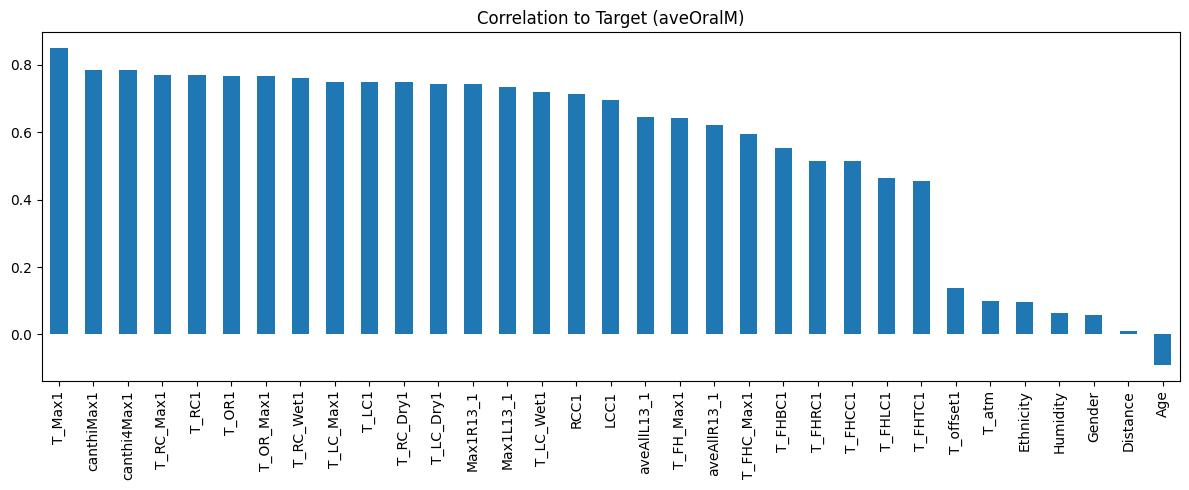

In [26]:
# Correlation
correlation = pd.DataFrame(X_imputed, columns=X.columns).corrwith(y)
correlation.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Correlation to Target (aveOralM)")
plt.tight_layout()
plt.show()